In [1]:
import torch

from torch_cubic_spline_grids import CubicBSplineGrid2d

some variables we can set...

In [2]:
N_CONTROL_POINTS = (8, 12)
N_OBSERVATIONS_PER_ITERATION = 100

initialise our optimisable parameters, a 2D grid of uniformly spaced
points

In [3]:
grid_2d = CubicBSplineGrid2d(resolution=N_CONTROL_POINTS)

define a function for making observations over the interval `[0, 1]` covering our 1d
grid

In [4]:
def make_observations(n, add_noise: bool = False):
    x = torch.rand((n, 2))  # in range [0, 1]
    y = torch.sin(2 * torch.pi * x[:, 0]) + torch.sin(4 * torch.pi * x[:, 1])
    if add_noise is True:
        y += torch.normal(torch.zeros((n, )), std=0.5)
    return x, y

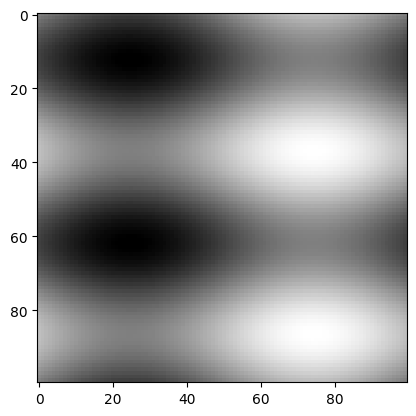

In [5]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
_x = _y = np.linspace(0, 1, 100)
x, y = np.meshgrid(_x, _y)
target_image = np.sin(2 * np.pi * x) + np.sin(4 * np.pi * y)
ax.imshow(target_image, cmap='gray_r')

initialise the optimiser

In [6]:
optimiser = torch.optim.Adam(grid_2d.parameters(), lr=0.01)

optimise the values at the control points such that interpolating between them with
cubic B-spline interpolation fits the data

10.489236831665039
9.499753952026367
9.269181251525879
10.214693069458008
9.430621147155762
9.8775053024292
8.687783241271973
10.003183364868164
8.835667610168457
8.521949768066406
9.705357551574707
9.214498519897461
8.105584144592285
8.05217456817627
9.79781436920166
8.145234107971191
9.680355072021484
8.114592552185059
8.844840049743652
7.99788761138916
9.279026985168457
8.015756607055664
8.557657241821289
8.823944091796875
8.009686470031738
8.288483619689941
8.902904510498047
6.997701168060303
7.918952941894531
7.725444316864014
8.967260360717773
7.809635162353516
8.118449211120605
7.320798873901367
8.218809127807617
8.034379005432129
7.736964225769043
7.376760959625244
7.9202165603637695
7.725559234619141
7.226182460784912
8.136855125427246
7.044098377227783
7.826513290405273
6.998807907104492
8.029684066772461
6.694702625274658
6.831555366516113
7.390711784362793
7.484253406524658
6.610850811004639
7.0271077156066895
7.0856032371521
6.792243003845215
7.714338302612305
6.8613705635

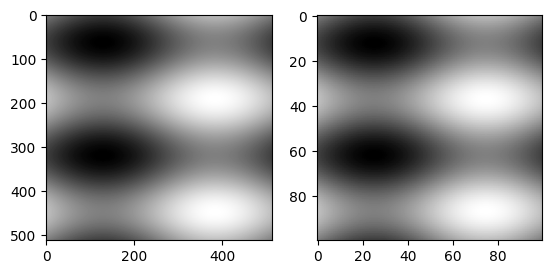

In [7]:
for i in range(500):
    # make (noisy) observations of the data we want to model
    x, y = make_observations(N_OBSERVATIONS_PER_ITERATION, add_noise=False)

    # what does the model predict for our observations?
    prediction = grid_2d(x).squeeze()

    # zero gradients and calculate loss between observations and model prediction
    optimiser.zero_grad()
    loss = torch.sum((prediction - y)**2)**0.5

    # backpropagate loss and update values at points on grid
    loss.backward()
    optimiser.step()
    print(loss.item())

n = 512
x = torch.tensor(np.linspace([0, 0], [1, 1], n))
xx, yy = torch.meshgrid(x[:, 0], x[:, 1], indexing='xy')
y = grid_2d(torch.stack((xx, yy), dim=-1)).detach().numpy().reshape(512, 512)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(y, cmap='gray_r', label='prediction')
ax[1].imshow(target_image, cmap='gray_r', label='ground truth')

this model has very little capacity to overfit to noisy data because of the small
number of points on our grid (parameters)